In [1]:
from IPython.core.display import display, HTML
import math
import pandas as pd

import mlos.global_values as global_values
from mlos.Optimizers.BayesianOptimizerFactory import BayesianOptimizerFactory
from mlos.Optimizers.BayesianOptimizerConfigStore import bayesian_optimizer_config_store
from mlos.Optimizers.OptimizationProblem import OptimizationProblem, Objective
from mlos.Spaces import ContinuousDimension, Point, SimpleHypergrid
from mlos.Tracer import Tracer

display(HTML("<style>.container { width:100% !important; }</style>"))

global_values.declare_singletons()
global_values.tracer = Tracer(actor_id="MetaOptimizer", thread_id=0)

# Let's stand up the Optimizer Microservice
#
optimizer_factory = BayesianOptimizerFactory()

In [2]:
# Let's make a meta optimizer.
#
meta_optimizer_config = bayesian_optimizer_config_store.get_config_by_name("default_with_glow_worm")
meta_optimizer_config.homogeneous_random_forest_regression_model_config.n_estimators = 50
meta_optimizer_config.homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.n_new_samples_before_refit = 5
meta_optimizer_config.experiment_designer_config.fraction_random_suggestions = 0.5

meta_optimizer = optimizer_factory.create_local_optimizer(
    optimizer_config=meta_optimizer_config,
    optimization_problem=OptimizationProblem(
        parameter_space=bayesian_optimizer_config_store.parameter_space,
        objective_space=SimpleHypergrid(
            name="predictions",
            dimensions=[
                ContinuousDimension(name="optimum_value_after_100_iterations", min=-math.inf, max=math.inf)
            ]
        ),
        objectives=[Objective(name='optimum_value_after_100_iterations', minimize=True)]
    )
)

09/29/2020 22:28:21 -   BayesianOptimizerFactory -    INFO - [BayesianOptimizerFactory.py:  40 -    create_local_optimizer() ] Creating a bayesian optimizer with config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 10,
  "homogeneous_random_forest_regression_model_config.n_estimators": 50,
  "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 1,
  "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "mse",
  "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "best",
  "homogeneous_random_forest_regression_mod

In [3]:
from mlos.OptimizerEvaluationTools.ObjectiveFunctionFactory import ObjectiveFunctionFactory
from mlos.OptimizerEvaluationTools.ObjectiveFunctionConfigStore import objective_function_config_store
objective_function_config = objective_function_config_store.get_config_by_name('three_level_quadratic')
objective_function = ObjectiveFunctionFactory.create_objective_function(objective_function_config)

print(objective_function_config.to_json(indent=2))

{
  "implementation": "ThreeLevelQuadratic"
}


In [4]:
print(objective_function.parameter_space)

  Name: three_level_quadratic_config
  Dimensions:
    vertex_height: {low, 5, 15}

  IF vertex_height IN {5} THEN (
    Name: medium_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )

  IF vertex_height IN {15} THEN (
    Name: high_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )

  IF vertex_height IN {low} THEN (
    Name: low_quadratic_params
    Dimensions:
      x_1: [-100.00, 100.00]
      x_2: [-100.00, 100.00]
  )


In [5]:
from mlos.Logger import create_logger
from mlos.Optimizers.RegressionModels.RegressionModelFitState import RegressionModelFitState

# Let us set up the lists to track optima over time.
#
best_observation_num_observations = []
best_observation_configs = []
best_observations = []

predicted_value_num_observations = []
best_predicted_value_configs = []
best_predicted_values = []

regression_model_fit_state = RegressionModelFitState()

In [6]:
logger = create_logger("Optimizing.")
num_completed_outer_loop_iterations = 0

In [7]:
import concurrent.futures
from mlos.Optimizers.OptimumDefinition import OptimumDefinition
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import GoodnessOfFitMetrics, DataSetType
from mlos.OptimizerEvaluationTools.ParallelOptimization import run_optimization



num_desired_runs = 500
num_completed_runs = 0
max_concurrent_jobs = 15 # To keep them all saturated.
max_workers = 7 # Leaving one logical core on my box.

with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    outstanding_futures = set()
    while num_completed_runs < num_desired_runs:
        logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")

        # Let's keep submitting new jobs to the pool until we have the desired number of executions.
        #
        num_remaining_jobs_to_schedule = num_desired_runs - num_completed_runs - len(outstanding_futures)
        num_jobs_to_schedule_now = min(num_remaining_jobs_to_schedule, max_concurrent_jobs - len(outstanding_futures))
        if num_jobs_to_schedule_now > 0:
            for _ in range(num_jobs_to_schedule_now):
                logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
                logger.info(f"Getting suggestion from meta optimizer.")
                inner_optimizer_config = meta_optimizer.suggest()
                
                logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
                logger.info(f"Inner optimizer config: {inner_optimizer_config.to_json(indent=2)}")
                future = executor.submit(
                    run_optimization,
                    inner_optimizer_config.to_json(),
                    objective_function_config.to_json(),
                    num_iterations=100
                )
                outstanding_futures.add(future)

        # Now let's wait for any future to complete. 
        #
        logger.info("Waiting for futures to complete.")
        logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
        done_futures, outstanding_futures = concurrent.futures.wait(outstanding_futures, return_when=concurrent.futures.FIRST_COMPLETED)
        logger.info(f"{len(done_futures)} future(s) completed.")
        logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
        
        for future in done_futures:
            inner_optimizer_config_json, best_observation_value_json = future.result()
            inner_optimizer_config = Point.from_json(inner_optimizer_config_json)
            best_observation_value = Point.from_json(best_observation_value_json)
            logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
            logger.info(f"Registering {best_observation_value_json} with meta optimizer.")
            # TODO: Batch them.
            meta_optimizer.register(
                feature_values_pandas_frame=inner_optimizer_config.to_dataframe(),
                target_values_pandas_frame=Point(optimum_value_after_100_iterations=best_observation_value.y).to_dataframe()
            )
            logger.info(f"Completed: {num_completed_runs}, Desired: {num_desired_runs}, Outstanding: {len(outstanding_futures)}")
            logger.info(f"Registered observation with meta optimizer.")
            num_completed_runs += 1
            num_completed_outer_loop_iterations += 1
            
        ################################################################################################################################
        #
        #
        # TODO: Make these methods on a Convergence State.
        #
        #
        if meta_optimizer.trained:
            gof_metrics = meta_optimizer.compute_surrogate_model_goodness_of_fit()
            regression_model_fit_state.set_gof_metrics(data_set_type=DataSetType.TRAIN, gof_metrics=gof_metrics)

        best_observation_num_observations.append(num_completed_outer_loop_iterations)

        best_observation_config, best_observation = meta_optimizer.optimum(OptimumDefinition.BEST_OBSERVATION)    
        best_observation_configs.append(best_observation_config)
        best_observations.append(best_observation)

        try:
            best_predicted_value_config, best_predicted_value = meta_optimizer.optimum(OptimumDefinition.PREDICTED_VALUE_FOR_OBSERVED_CONFIG)
            best_predicted_value_configs.append(best_predicted_value_config)
            best_predicted_values.append(best_predicted_value)
            predicted_value_num_observations.append(num_completed_outer_loop_iterations)
        except:
            pass


09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  16 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 0
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 0
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 0
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_req

09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 3
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 3
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 16,
  "homogeneous_random_forest_regression_model_config.n_estimators": 36,
  "homogeneous_random_forest_regression_model_config.fe

09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 6
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 6
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 22,
  "homogeneous_random_forest_regression_model_config.n_estimators": 78,
  "homogeneous_random_forest_regression_model_config.fe

09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 9
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 9
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 70,
  "homogeneous_random_forest_regression_model_config.n_estimators": 89,
  "homogeneous_random_forest_regression_model_config.fe

09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 12
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 12
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 89,
  "homogeneous_random_forest_regression_model_config.n_estimators": 78,
  "homogeneous_random_forest_regression_model_config.

09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 14
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 0, Desired: 50, Outstanding: 14
09/29/2020 22:28:38 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 94,
  "homogeneous_random_forest_regression_model_config.n_estimators": 118,
  "homogeneous_random_forest_regression_model_config

09/29/2020 22:28:41 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  40 -                  <module>() ] Waiting for futures to complete.
09/29/2020 22:28:41 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  41 -                  <module>() ] Completed: 1, Desired: 50, Outstanding: 15
09/29/2020 22:28:41 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  43 -                  <module>() ] 9 future(s) completed.
09/29/2020 22:28:41 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  44 -                  <module>() ] Completed: 1, Desired: 50, Outstanding: 6
09/29/2020 22:28:41 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  50 -                  <module>() ] Completed: 1, Desired: 50, Outstanding: 6
09/29/2020 22:28:41 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  51 -                  <module>() ] Registering {"y": 1309.1213840595622}

09/29/2020 22:28:41 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 10, Desired: 50, Outstanding: 7
09/29/2020 22:28:41 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:28:42 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 10, Desired: 50, Outstanding: 7
09/29/2020 22:28:42 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 49,
  "homogeneous_random_forest_regression_model_config.n_estimators": 113,
  "homogeneous_random_forest_regression_model_config

09/29/2020 22:28:42 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 10, Desired: 50, Outstanding: 10
09/29/2020 22:28:42 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:28:42 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 10, Desired: 50, Outstanding: 10
09/29/2020 22:28:42 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 70,
  "homogeneous_random_forest_regression_model_config.n_estimators": 10,
  "homogeneous_random_forest_regression_model_confi

09/29/2020 22:28:42 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 10, Desired: 50, Outstanding: 13
09/29/2020 22:28:42 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:28:43 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 10, Desired: 50, Outstanding: 13
09/29/2020 22:28:43 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 24,
  "homogeneous_random_forest_regression_model_config.n_estimators": 65,
  "homogeneous_random_forest_regression_model_confi

09/29/2020 22:28:43 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  50 -                  <module>() ] Completed: 10, Desired: 50, Outstanding: 2
09/29/2020 22:28:43 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  51 -                  <module>() ] Registering {"y": 475.5140068437002} with meta optimizer.
09/29/2020 22:28:43 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  57 -                  <module>() ] Completed: 10, Desired: 50, Outstanding: 2
09/29/2020 22:28:43 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  58 -                  <module>() ] Registered observation with meta optimizer.
09/29/2020 22:28:43 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  50 -                  <module>() ] Completed: 11, Desired: 50, Outstanding: 2
09/29/2020 22:28:43 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  51 -                  <m

09/29/2020 22:28:45 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  58 -                  <module>() ] Registered observation with meta optimizer.
09/29/2020 22:28:45 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  50 -                  <module>() ] Completed: 22, Desired: 50, Outstanding: 2
09/29/2020 22:28:45 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  51 -                  <module>() ] Registering {"y": 1394.1767363712843} with meta optimizer.
09/29/2020 22:28:45 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  57 -                  <module>() ] Completed: 22, Desired: 50, Outstanding: 2
09/29/2020 22:28:45 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  58 -                  <module>() ] Registered observation with meta optimizer.
09/29/2020 22:28:47 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  16 -                  

09/29/2020 22:28:47 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 23, Desired: 50, Outstanding: 4
09/29/2020 22:28:47 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:28:47 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 23, Desired: 50, Outstanding: 4
09/29/2020 22:28:47 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 48,
  "homogeneous_random_forest_regression_model_config.n_estimators": 43,
  "homogeneous_random_forest_regression_model_config.

09/29/2020 22:28:58 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 23, Desired: 50, Outstanding: 7
09/29/2020 22:28:58 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:28:58 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 23, Desired: 50, Outstanding: 7
09/29/2020 22:28:58 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 35,
  "homogeneous_random_forest_regression_model_config.n_estimators": 45,
  "homogeneous_random_forest_regression_model_config.

09/29/2020 22:29:21 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 23, Desired: 50, Outstanding: 10
09/29/2020 22:29:21 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:29:21 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 23, Desired: 50, Outstanding: 10
09/29/2020 22:29:21 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 3,
  "homogeneous_random_forest_regression_model_config.n_estimators": 32,
  "homogeneous_random_forest_regression_model_config

09/29/2020 22:29:32 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 23, Desired: 50, Outstanding: 13
09/29/2020 22:29:32 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:29:43 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 23, Desired: 50, Outstanding: 13
09/29/2020 22:29:43 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 82,
  "homogeneous_random_forest_regression_model_config.n_estimators": 15,
  "homogeneous_random_forest_regression_model_confi

09/29/2020 22:29:55 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  51 -                  <module>() ] Registering {"y": 116.1427990998756} with meta optimizer.
09/29/2020 22:29:55 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  57 -                  <module>() ] Completed: 24, Desired: 50, Outstanding: 1
09/29/2020 22:29:55 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  58 -                  <module>() ] Registered observation with meta optimizer.
09/29/2020 22:29:55 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  50 -                  <module>() ] Completed: 25, Desired: 50, Outstanding: 1
09/29/2020 22:29:55 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  51 -                  <module>() ] Registering {"y": 456.9917614429935} with meta optimizer.
09/29/2020 22:29:55 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  57 -     

09/29/2020 22:29:56 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  50 -                  <module>() ] Completed: 36, Desired: 50, Outstanding: 1
09/29/2020 22:29:56 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  51 -                  <module>() ] Registering {"y": 726.5825170906238} with meta optimizer.
09/29/2020 22:29:57 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  57 -                  <module>() ] Completed: 36, Desired: 50, Outstanding: 1
09/29/2020 22:29:57 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  58 -                  <module>() ] Registered observation with meta optimizer.
09/29/2020 22:30:02 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  16 -                  <module>() ] Completed: 37, Desired: 50, Outstanding: 1
09/29/2020 22:30:02 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <m

09/29/2020 22:30:28 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 37, Desired: 50, Outstanding: 4
09/29/2020 22:30:28 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:30:56 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 37, Desired: 50, Outstanding: 4
09/29/2020 22:30:56 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 60,
  "homogeneous_random_forest_regression_model_config.n_estimators": 12,
  "homogeneous_random_forest_regression_model_config.

09/29/2020 22:30:56 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 37, Desired: 50, Outstanding: 7
09/29/2020 22:30:56 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:30:56 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 37, Desired: 50, Outstanding: 7
09/29/2020 22:30:56 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 32,
  "homogeneous_random_forest_regression_model_config.n_estimators": 42,
  "homogeneous_random_forest_regression_model_config.

09/29/2020 22:31:49 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  24 -                  <module>() ] Completed: 37, Desired: 50, Outstanding: 10
09/29/2020 22:31:49 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  25 -                  <module>() ] Getting suggestion from meta optimizer.
09/29/2020 22:31:49 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  28 -                  <module>() ] Completed: 37, Desired: 50, Outstanding: 10
09/29/2020 22:31:49 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  29 -                  <module>() ] Inner optimizer config: {
  "surrogate_model_implementation": "HomogeneousRandomForestRegressionModel",
  "experiment_designer_implementation": "ExperimentDesigner",
  "min_samples_required_for_guided_design_of_experiments": 27,
  "homogeneous_random_forest_regression_model_config.n_estimators": 124,
  "homogeneous_random_forest_regression_model_conf

09/29/2020 22:32:16 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  40 -                  <module>() ] Waiting for futures to complete.
09/29/2020 22:32:16 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  41 -                  <module>() ] Completed: 37, Desired: 50, Outstanding: 13
09/29/2020 22:32:16 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  43 -                  <module>() ] 11 future(s) completed.
09/29/2020 22:32:16 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  44 -                  <module>() ] Completed: 37, Desired: 50, Outstanding: 2
09/29/2020 22:32:16 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  50 -                  <module>() ] Completed: 37, Desired: 50, Outstanding: 2
09/29/2020 22:32:16 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  51 -                  <module>() ] Registering {"y": 594.56863502637

09/29/2020 22:32:18 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  58 -                  <module>() ] Registered observation with meta optimizer.
09/29/2020 22:32:23 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  16 -                  <module>() ] Completed: 48, Desired: 50, Outstanding: 2
09/29/2020 22:32:23 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  40 -                  <module>() ] Waiting for futures to complete.
09/29/2020 22:32:23 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  41 -                  <module>() ] Completed: 48, Desired: 50, Outstanding: 2
09/29/2020 22:32:23 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  43 -                  <module>() ] 2 future(s) completed.
09/29/2020 22:32:23 -                Optimizing. -    INFO - [<ipython-input-7-46cd9dd8f3ad>:  44 -                  <module>() ] Completed: 48, Desired: 50, Outsta

In [8]:
best_observation_config, best_observation

({"surrogate_model_implementation": "HomogeneousRandomForestRegressionModel", "experiment_designer_implementation": "ExperimentDesigner", "min_samples_required_for_guided_design_of_experiments": 18, "homogeneous_random_forest_regression_model_config.n_estimators": 108, "homogeneous_random_forest_regression_model_config.features_fraction_per_estimator": 0.12415351500311289, "homogeneous_random_forest_regression_model_config.samples_fraction_per_estimator": 0.5563201618497201, "homogeneous_random_forest_regression_model_config.regressor_implementation": "DecisionTreeRegressionModel", "homogeneous_random_forest_regression_model_config.bootstrap": 1, "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.criterion": "friedman_mse", "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.splitter": "random", "homogeneous_random_forest_regression_model_config.decision_tree_regression_model_config.max_depth": 843, "homogeneous

In [9]:
best_predicted_value_config, best_predicted_value

({"surrogate_model_implementation": "HomogeneousRandomForestRegressionModel", "experiment_designer_implementation": "ExperimentDesigner", "min_samples_required_for_guided_design_of_experiments": 40, "homogeneous_random_forest_regression_model_config___n_estimators": 21, "homogeneous_random_forest_regression_model_config___features_fraction_per_estimator": 0.7770438920825872, "homogeneous_random_forest_regression_model_config___samples_fraction_per_estimator": 0.7639212909639075, "homogeneous_random_forest_regression_model_config___regressor_implementation": "DecisionTreeRegressionModel", "homogeneous_random_forest_regression_model_config___bootstrap": 0, "homogeneous_random_forest_regression_model_config___decision_tree_regression_model_config___criterion": "friedman_mse", "homogeneous_random_forest_regression_model_config___decision_tree_regression_model_config___splitter": "best", "homogeneous_random_forest_regression_model_config___decision_tree_regression_model_config___max_depth":

In [10]:
# Best observation dataframe
#
best_observation_df = pd.DataFrame([observation.to_dict() for observation in best_observations])
best_observation_df['num_observations'] = best_observation_num_observations
best_observation_df = pd.concat([best_observation_df.drop_duplicates(subset=['optimum_value_after_100_iterations'], keep='last'), best_observation_df.drop_duplicates(subset=['optimum_value_after_100_iterations'], keep='first')]).sort_index()
best_observation_df

,optimum_value_after_100_iterations,num_observations
0,170.972537,1
1,170.972537,10
2,118.996859,23
2,118.996859,23
3,80.683807,37
4,80.683807,48
5,26.549423,50
5,26.549423,50


In [11]:
best_predicted_value_df = pd.DataFrame([predicted_value.to_dict() for predicted_value in best_predicted_values])
best_predicted_value_df['num_observations'] = predicted_value_num_observations
best_predicted_value_df = pd.concat([best_predicted_value_df.drop_duplicates(subset=['predicted_value'], keep='last'), best_predicted_value_df.drop_duplicates(subset=['predicted_value'], keep='first')]).sort_index()
best_predicted_value_df

,predicted_value,num_observations
0,623.480242,23
0,623.480242,23
1,431.239070,37
3,431.239070,50


C:\Users\adsmiech\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


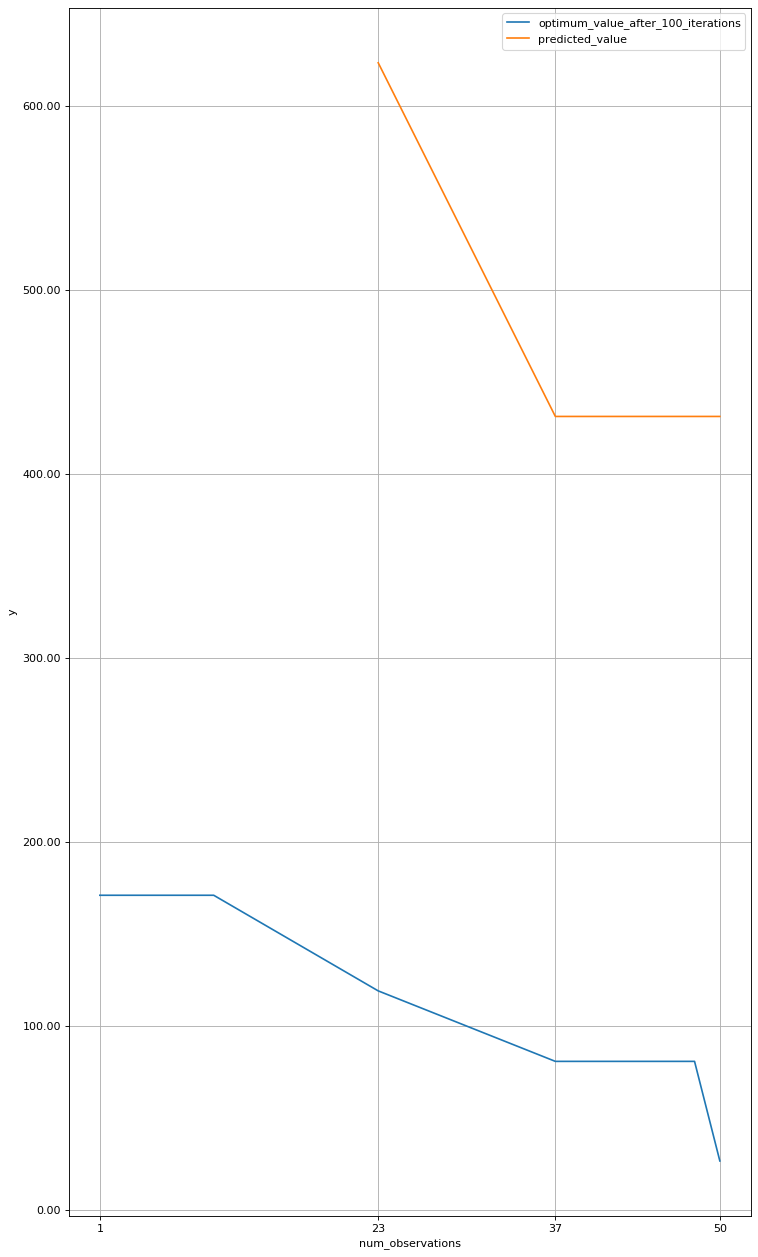

In [12]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

fig, axs = plt.subplots(1, figsize=(11, 20), dpi=80, sharex=True)

axs.plot(best_observation_df['num_observations'], best_observation_df['optimum_value_after_100_iterations'], label='optimum_value_after_100_iterations')
axs.plot(best_predicted_value_df['num_observations'], best_predicted_value_df['predicted_value'], label='predicted_value')
axs.set_ylabel('y')
axs.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
axs.set_xticks(best_observation_df['num_observations'][::2])
axs.grid(True)
axs.set_xlabel('num_observations')
axs.legend()  
fig.show()

In [13]:
from mlos.Optimizers.RegressionModels.GoodnessOfFitMetrics import DataSetType

# Let's take a look at goodness of fit data.
#
goodness_of_fit_dataframe = regression_model_fit_state.get_goodness_of_fit_dataframe(data_set_type=DataSetType.TRAIN) # TODO: add support to evaluate GoF on test data

C:\Users\adsmiech\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:19: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


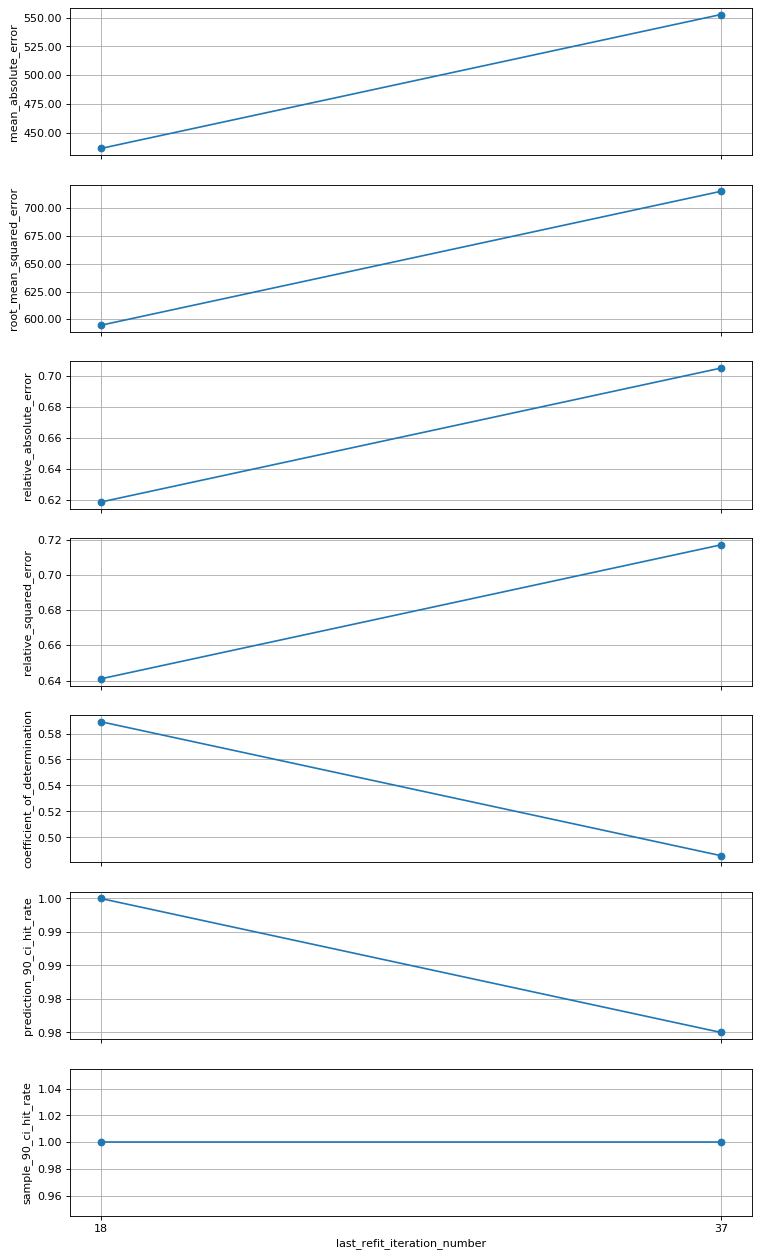

In [14]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

gof_df = goodness_of_fit_dataframe
columns_to_plot = [name for name in gof_df.columns.values if name not in ('observation_count', 'prediction_count', 'last_refit_iteration_number')]
num_plots = len(columns_to_plot)
fig, axs = plt.subplots(num_plots, figsize=(11, 20), dpi=80, sharex=True)

for i, column in enumerate(columns_to_plot):
    axs[i].plot(gof_df['last_refit_iteration_number'], gof_df[column], marker='o', label=column)
    axs[i].set_ylabel(column)
    axs[i].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    axs[i].set_xticks(gof_df['last_refit_iteration_number'])
    axs[i].grid(True)
    if i == num_plots - 1:
        axs[i].set_xlabel('last_refit_iteration_number')
        
fig.show()

In [ ]:
global_values.tracer.dump_trace_to_file(r"E:\code\new_mlos\source\Mlos.Python\temp\meta_optimizer.json")